In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer,BertModel

path = "C:/ML/python/data/data.csv"
df = pd.read_csv(path)
df.info()
df.isna().sum()
df.duplicated().sum()
df.drop_duplicates(inplace=True)



df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


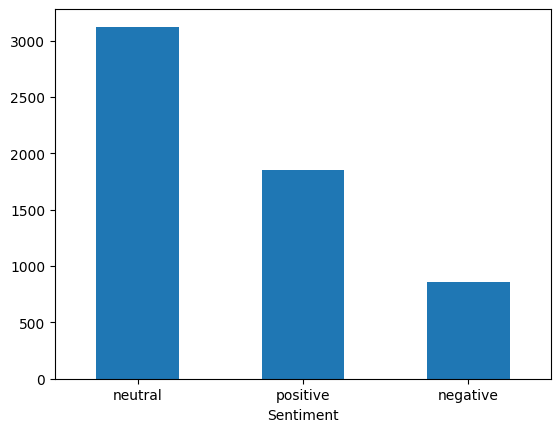

In [2]:
df['Sentiment'].value_counts().plot(kind='bar',rot=0)
plt.show()

In [3]:
df['text'] = df['Sentence']
df.drop("Sentence",axis=1,inplace=True)


In [4]:
df['text'].head(10)

0    The GeoSolutions technology will leverage Bene...
1    $ESI on lows, down $1.50 to $2.50 BK a real po...
2    For the last quarter of 2010 , Componenta 's n...
3    According to the Finnish-Russian Chamber of Co...
4    The Swedish buyout firm has sold its remaining...
5      $SPY wouldn't be surprised to see a green close
6    Shell's $70 Billion BG Deal Meets Shareholder ...
7    SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...
8    Kone 's net sales rose by some 14 % year-on-ye...
9    The Stockmann department store will have a tot...
Name: text, dtype: object

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


sample_text_with_negative_sentiment = " HEY, YOU!? What on Earth are you looking at you FOOL!? do not just stand there, go!"
tokenizer(sample_text_with_negative_sentiment)

from transformers import pipeline
senitment_neg = pipeline("sentiment-analysis")

print("the senitment score of the negative text: ",senitment_neg(sample_text_with_negative_sentiment))

### ok
postive_sentiment = "I love you so much it hurts"
print("the senitment score of the nice text: ",senitment_neg(postive_sentiment))





No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


the senitment score of the negative text:  [{'label': 'NEGATIVE', 'score': 0.9855140447616577}]
the senitment score of the nice text:  [{'label': 'POSITIVE', 'score': 0.5755005478858948}]


In [11]:
### ok
train_size = 0.8

df_train = df.sample(frac=train_size,random_state=42).reset_index(drop=True)
df_val = df.sample(frac=0.05,random_state=42).reset_index(drop=True)

MAX_LEN = 512


train_batch_size = 32
num_epochs = 4
learning_rate=1e-05
val_batch_size = 32

from torch.utils.data import Dataset


class FinanceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.title = self.df['text'].values.tolist()
        self.targets = self.df['Sentiment'].tolist() 
    
    def __len__(self):
        return len(self.title)
    
    def __getitem__(self, index: int):
        single_row = self.df.iloc[index]
        text_ = single_row['text']
        labels = single_row['Sentiment']

        inputs = self.tokenizer.encode_plus(
            text_,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        

        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        token_type_ids = inputs['token_type_ids'].flatten()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'targets': torch.tensor(labels, dtype=torch.float)
        }
        



training_data = FinanceDataset(df_train, tokenizer, MAX_LEN)
val_data = FinanceDataset(df_val, tokenizer, MAX_LEN)


from torch.utils.data import DataLoader

train_loader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=val_batch_size, shuffle=False)


In [12]:
from transformers import BertModel

class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768,6)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()



In [13]:
import torch.optim as optim


loss_fn = nn.CrossEntropyLoss()



optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(data_loader)

### this is so fucking hard
## coming back later
